<h1> KNeighborsClassifier <h1>

Hauptkomponentenanalyse vor KNN?

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [72]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [73]:
def split_train_test(df):
    random_state = 4711
    features = [x for x in df.columns if x!= "RESP"]
    X = df[features]
    y = df["RESP"]
    X_train, X_test_2, y_train, y_test_2 = train_test_split(X, y, test_size = 0.05, random_state=random_state)
    X_train, X_test_1, y_train, y_test_1 = train_test_split(X_train, y_train, test_size = 0.2, random_state=random_state)
    return X_train, X_test_2, y_train, y_test_2, X_test_1, y_test_1

In [74]:
def get_result_score(y_test, y_predicted):

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    y_true = y_test.to_list()
    y_predicted = y_predicted.tolist()

    for i in range(len(y_predicted)):
        if y_true[i]==y_predicted[i]==1:
            TP += 1
        if y_predicted[i]==1 and y_true[i]!=y_predicted[i]:
            FP += 1
        if y_true[i]==y_predicted[i]==0:
            TN += 1
        if y_predicted[i]==0 and y_true[i]!=y_predicted[i]:
            FN += 1


    return (TP*16+FP*(-2)+TN*(0)+FN*(-16))

In [75]:
path = r'./out/df_clean.csv'
df = pd.read_csv(path, sep=';', decimal=',')

In [76]:
df.head()

,ZIP_CODE,DAYS_SINCE_PURCHASE,PURCHASE_VISITS,TOTAL_NET_SALES,CC_CARD,AVE_AMOUNT_SPENT,AMSPEND,PSSPEND,CCSPEND,AXSPEND,...,CLUSTYPE_Cluster_46,CLUSTYPE_Cluster_47,CLUSTYPE_Cluster_48,CLUSTYPE_Cluster_49,CLUSTYPE_Cluster_5,CLUSTYPE_Cluster_50,CLUSTYPE_Cluster_6,CLUSTYPE_Cluster_7,CLUSTYPE_Cluster_8,CLUSTYPE_Cluster_9
0,1001,208,2,368.46,0,184.23,0.0,0.0,368.46,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1028,6,4,258.00,1,64.50,0.0,0.0,258.00,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1056,327,2,77.00,0,38.50,0.0,0.0,77.00,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1118,66,8,846.06,1,105.75,0.0,0.0,846.06,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1107,49,1,87.44,0,87.44,0.0,0.0,87.44,0.0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
X_train, X_test_2, y_train, y_test_2, X_test_1, y_test_1 = split_train_test(df)

In [78]:
X_train.head()

,ZIP_CODE,DAYS_SINCE_PURCHASE,PURCHASE_VISITS,TOTAL_NET_SALES,CC_CARD,AVE_AMOUNT_SPENT,AMSPEND,PSSPEND,CCSPEND,AXSPEND,...,CLUSTYPE_Cluster_46,CLUSTYPE_Cluster_47,CLUSTYPE_Cluster_48,CLUSTYPE_Cluster_49,CLUSTYPE_Cluster_5,CLUSTYPE_Cluster_50,CLUSTYPE_Cluster_6,CLUSTYPE_Cluster_7,CLUSTYPE_Cluster_8,CLUSTYPE_Cluster_9
10016,8215,331,1,108.00,0,108.00,0.0,49.00,59.00,0.0,...,0,0,0,0,0,0,0,0,0,0
8232,40207,27,1,255.60,1,255.60,0.0,0.00,255.60,0.0,...,0,0,0,0,0,0,0,0,0,0
17428,47724,47,8,431.24,0,53.90,0.0,391.95,39.29,0.0,...,0,0,0,0,0,1,0,0,0,0
16268,67428,153,3,299.00,1,99.66,0.0,138.00,161.00,0.0,...,0,0,0,0,0,0,0,0,0,0
18733,77070,6,1,72.98,0,72.98,0.0,64.98,8.00,0.0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
skBest_chi = SelectKBest(chi2, k=10)
bestfeatures_chi = skBest_chi.fit(X_train,y_train)
X_train.columns[bestfeatures_chi.get_support(indices=True)].tolist()

['DAYS_SINCE_PURCHASE',
 'TOTAL_NET_SALES',
 'PSSPEND',
 'CCSPEND',
 'TMONSPEND',
 'OMONSPEND',
 'SMONSPEND',
 'PREVPD',
 'FREDAYS',
 'LTFREDAY']

In [80]:
"""indices = np.argsort(bestfeatures_chi.scores_)[::-1]
features = []
for i in range(10):
    features.append(X_train.columns[indices[i]])
plt.figure(figsize = (20, 6))
plt.bar(features, bestfeatures_chi.scores_[indices[range(10)]], color = "r", align="center")
plt.show()"""

'indices = np.argsort(bestfeatures_chi.scores_)[::-1]\nfeatures = []\nfor i in range(10):\n    features.append(X_train.columns[indices[i]])\nplt.figure(figsize = (20, 6))\nplt.bar(features, bestfeatures_chi.scores_[indices[range(10)]], color = "r", align="center")\nplt.show()'

In [81]:
skBest_classif = SelectKBest(f_classif, k=10)
bestfeatures_classif = skBest_classif.fit(X_train,y_train)
X_train.columns[bestfeatures_chi.get_support(indices=True)].tolist()

['DAYS_SINCE_PURCHASE',
 'TOTAL_NET_SALES',
 'PSSPEND',
 'CCSPEND',
 'TMONSPEND',
 'OMONSPEND',
 'SMONSPEND',
 'PREVPD',
 'FREDAYS',
 'LTFREDAY']

In [82]:
cols_idxs = bestfeatures_classif.get_support(indices=True)
X_train = X_train.iloc[:,cols_idxs]
X_test_1 = X_test_1.iloc[:,cols_idxs]
X_test_2 = X_test_2.iloc[:,cols_idxs]

In [83]:
X_train

,PURCHASE_VISITS,TOTAL_NET_SALES,SMONSPEND,CLASSES,COUPONS,STYLES,STORES,RESPONDED,RESPONSERATE,LTFREDAY
10016,1,108.00,0.00,2,0,3,2,0,0.0000,165.50
8232,1,255.60,255.60,4,1,4,1,0,0.0000,27.00
17428,8,431.24,234.98,5,0,17,3,2,0.2222,35.66
16268,3,299.00,10.00,4,2,7,2,2,0.2000,51.33
18733,1,72.98,72.98,2,0,3,2,0,0.0000,56.22
...,...,...,...,...,...,...,...,...,...,...
14041,8,479.18,0.00,5,0,16,3,0,0.0000,40.33
17160,11,1849.89,692.94,18,2,54,3,5,0.4545,29.95
19997,1,187.00,0.00,3,0,3,1,0,0.0000,111.00
3286,4,142.99,0.00,5,0,8,2,0,0.0000,42.35


### Scaling on z-values
### Auf Pipeline achten! Skalierung innerhalb der Pipeline durchführen

In [84]:
std_slc = preprocessing.StandardScaler()
knn = KNeighborsClassifier()

In [85]:
pipe = Pipeline(steps=[("std_slc", std_slc),
                       ("KNN",knn)])

In [86]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('std_slc', StandardScaler()), ('KNN', KNeighborsClassifier())])

In [87]:
mean_acc = np.zeros(30)
mean_score = np.zeros(30)
for i in range(1,31):
    pipe.set_params(KNN__n_neighbors=i).fit(X_train, y_train)
    y_predicted = pipe.predict(X_test_1)
    mean_acc[i-1] = metrics.accuracy_score(y_test_1, y_predicted)
    mean_score[i-1] = get_result_score(y_test_1, y_predicted)

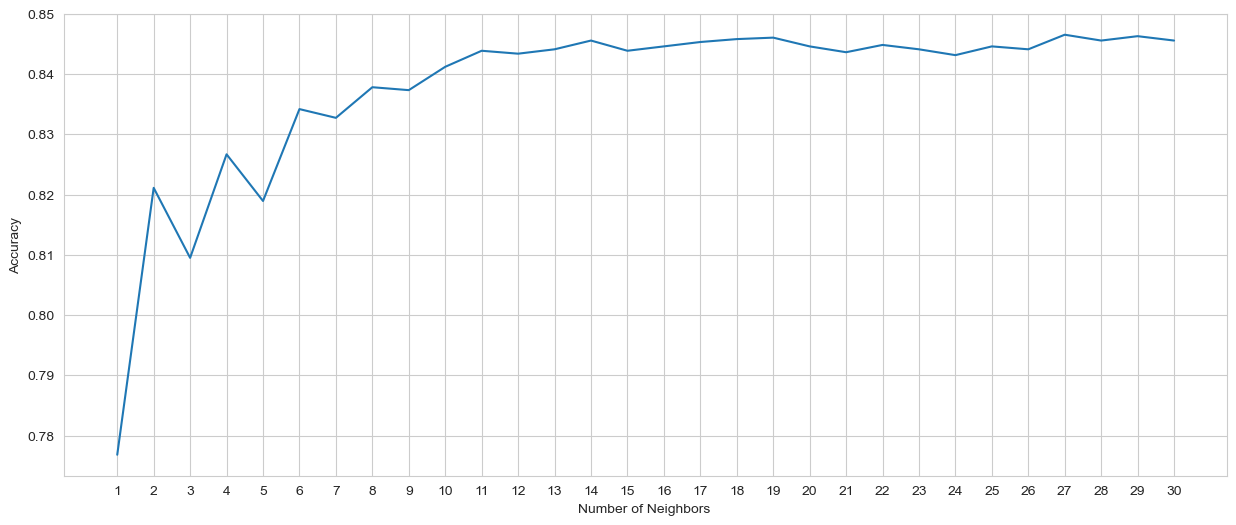

In [88]:
loc = np.arange(1,31,step=1.0)
plt.figure(figsize = (15, 6))
plt.plot(range(1,31), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

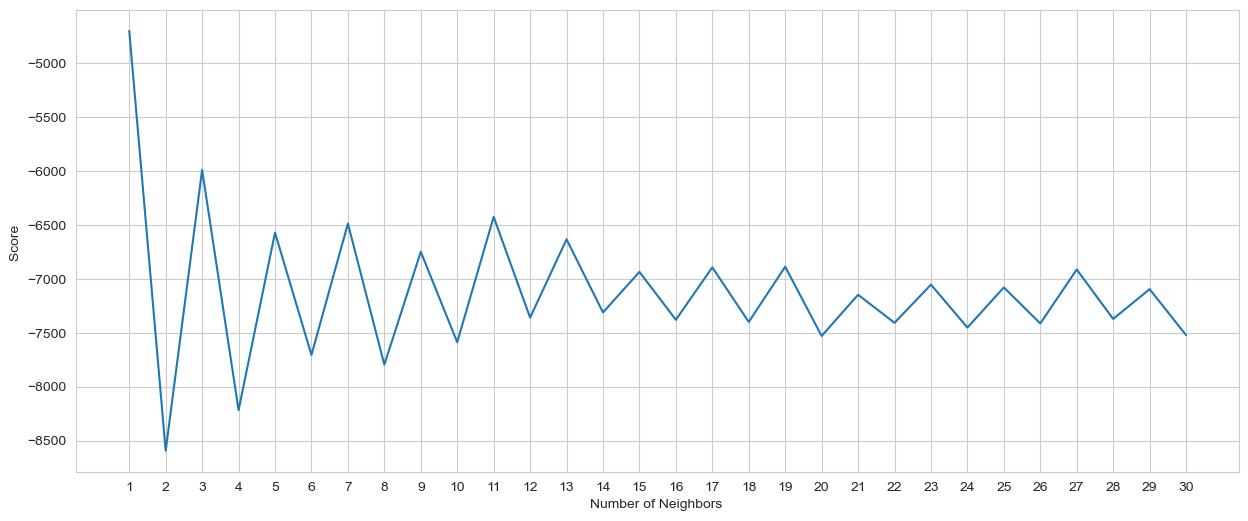

In [89]:
loc = np.arange(1, 31, step=1.0)
plt.figure(figsize=(15, 6))
plt.plot(range(1, 31), mean_score)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Score ')
plt.show()

In [90]:
grid_params = {"n_neighbors" : [1,2,5,7,9,11,13,15,17,19,20],
               "weights" : ["uniform","distance"],
               }
knn = KNeighborsClassifier()
result_scorer = make_scorer(get_result_score)
knn_random_result_score = GridSearchCV(estimator = knn, param_grid = grid_params,
                                       cv = 3, n_jobs = -1, scoring = result_scorer)
knn_random_result_accuracy = GridSearchCV(estimator = knn, param_grid = grid_params,
                                          cv = 3, n_jobs = -1)
knn_random_result_recall = GridSearchCV(estimator = knn, param_grid = grid_params,
                                        cv = 3, n_jobs = -1, scoring = "recall")
knn_random_result_score_res = knn_random_result_score.fit(X_train, y_train)
knn_random_result_accuracy_res = knn_random_result_accuracy.fit(X_train, y_train)
knn_random_result_recall_res = knn_random_result_recall.fit(X_train, y_train)

print("Bester Score: ",knn_random_result_score_res.best_score_)
print("Mit Parametern: ",knn_random_result_score_res.best_params_)
print("Beste Accuracy: ",knn_random_result_accuracy_res.best_score_)
print("Mit Parametern: ",knn_random_result_accuracy_res.best_params_)
print("Bester Recall: ",knn_random_result_recall_res.best_score_)
print("Mit Parametern: ",knn_random_result_recall_res.best_params_)

Bester Score:  -6276.0
Mit Parametern:  {'n_neighbors': 1, 'weights': 'uniform'}
Beste Accuracy:  0.8391235036924244
Mit Parametern:  {'n_neighbors': 15, 'weights': 'uniform'}
Bester Recall:  0.3252658599193253
Mit Parametern:  {'n_neighbors': 1, 'weights': 'uniform'}


Accuracy:  58.785648574057035 %
Recall:  83.52941176470588 %
Precision:  25.26690391459075 %
F1 Score:  38.79781420765027 %
Score:  984


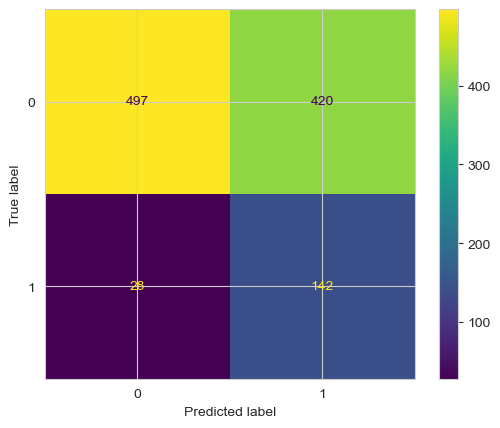

In [91]:
knn = KNeighborsClassifier(n_neighbors=17, weights="uniform")


knn.fit(X_train,y_train)
y_predicted = (knn.predict_proba(X_test_2)[:,1]>=0.1).astype(bool)
accuracy = accuracy_score(y_test_2, y_predicted)
precision = precision_score(y_test_2, y_predicted)
recall = recall_score(y_test_2, y_predicted)
f1score = f1_score(y_test_2, y_predicted)
score = get_result_score(y_test_2, y_predicted)

print("Accuracy: ",accuracy*100, "%")
print("Recall: ", recall*100, "%")
print("Precision: ", precision*100, "%")
print("F1 Score: ", f1score*100, "%")
print("Score: ", score)
matrix = confusion_matrix(y_test_2,y_predicted,labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=knn.classes_)
disp.plot()
plt.show()

<h2>Baseline Strategie<h2>

In [92]:
len(y_test_2)
count_RESP_yes = sum(y_test_2)
count_RESP_no = len(y_test_2) - sum(y_test_2)
baseline = (count_RESP_yes*16)+(count_RESP_no*(-2))
print(baseline)

886
